In [24]:
import argparse
import copy
import json
import os
import shutil

import cv2
import numpy as np
from utils.shape import node
from utils.tree import createtree
from utils.operation import *

from matplotlib import pyplot as plt
from IPython.display import Image


def Dimensioning(userId,view,image):

    #Creating temp directory if not present
    os.makedirs('static/temp', exist_ok=True)
    #Getting user input from app
    img = cv2.imread(image,cv2.IMREAD_UNCHANGED)
    #Initialization
    ratio = 0
    shape = "unidentified"
    #Getting the size of image
    w,h,_=img.shape
    drawSize = int(h/300)
    #Convert image to grayscale
    imgrey = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    #Convert image to black and white
    ret, thresh = cv2.threshold(imgrey,127,255,cv2.THRESH_BINARY_INV)
    #Find contours
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    #Arrange the contours in descending order of area
    hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))

    for i,c in enumerate(contours):
        #Get the outer most closed contour
        if(hierarchy[i][3] != -1  or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1) ):
            M = cv2.moments(c)
            if(M["m00"] !=0):
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                #Getting the minimum area rectangle enclosing the contour
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                #Getting horizontal rectangle enclosing the contour
                x,y,w,h = cv2.boundingRect(c)

                # cv2.putText(img, "#{}".format(i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                #     textSize, (255, 0, 0), drawSize,cv2.LINE_AA)

                # draw contours
                cv2.drawContours(img, [c], 0, (0,0, 255), drawSize)
                #detect Shape
                shape, cylinder_type = detect(c)
                #Length per pixel
                ratio = 1.0/rect[1][0]
                if(shape == "unidentified"):
                    continue
                #w is the width of the rectagle enclosing the circle, i.e diameter of the circle
                if(shape=="Circle"):
                    ratio = 1/w
                break
    
    #highlighted image path
    folder = 'static/temp/' + userId
    os.makedirs(folder, exist_ok=True)
    #Check whether file already exist and delete
    try:
        os.remove(folder + '/' + view + '.png')
    except: pass

    path_file = (folder + '/' + view + '.png')

    #reducing the image size
    small = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
    cv2.imwrite(path_file,small)
    #Convert float to string
    ratio = str(ratio)
    #Json data to send
    data={'image': path_file,'shape': shape,'ratio': ratio}
#     plt.imshow(image)
#     plt.show()
    display(Image(filename = path_file))
    return json.dumps(data)

In [25]:
def Convert(userId, front_image, side_image, top_image, fratio, sratio, tratio):
    os.makedirs('static', exist_ok=True)

    img_front = cv2.imread(front_image,cv2.IMREAD_UNCHANGED)
    img_side = cv2.imread(side_image,cv2.IMREAD_UNCHANGED)
    img_top = cv2.imread(top_image,cv2.IMREAD_UNCHANGED)

    fratio = float(fratio)
    sratio = float(sratio)
    tratio = float(tratio)
    filePath = "static/temp/"+userId
#Remove temp file created while dimensioning
    try:
        shutil.rmtree(filePath)
    except OSError as e:
        print ("Error: %s - %s." % (e.filename, e.strerror))

    primitive = []
    #front
    object_front = valid_contours(img_front,"front",fratio)
    re_arrange(object_front,"front")
    front_parts = []
    for object in object_front:
        for i in object:
            front_parts.append(i[0])
    
    #side
    object_side = valid_contours(img_side,"side",sratio)
    re_arrange(object_side,"side")
    side_parts = []
    for object in object_side:
        for i in object:
            side_parts.append(i[0])

    #Top
    object_top = valid_contours(img_top,"top",tratio)
    re_arrange(object_top,"top")
    top_parts = []
    for object in object_top:
        for i in object:
            top_parts.append(i[0])

    #Thershold error        
    minApprox = 4.0 * max(fratio,sratio,tratio)
    primitive = combining(object_front,object_side,object_top,minApprox)
    final = []
    for set in primitive:
        for shape in set:
            final.append(shape[0])
    
    #Check whether file already exist and delete
    try:
        os.remove('static/' + userId + '.scad')
    except: pass

    #Generate scad file
    path_file = ('static/' + userId + '.scad')
    #If the list is empty no shape has been detected
    if(len(final) == 0):
        path_file = 'static/error.txt'
        f = open(path_file, "w")
        f.write("Cannot determine the 3d geometry, check your files again!")
        f.close()
    createtree(final,path_file)

    return json.dumps(path_file)


In [26]:
userId="1"
front_image = "TestBench/2/front2.png"
side_image = "TestBench/2/side2.png"
top_image = "TestBench/2/top2.png"

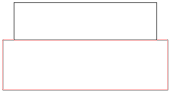

'{"image": "static/temp/1/front.png", "shape": "rectangle", "ratio": "0.0030303035907728883"}'

In [27]:
Dimensioning(userId,"front",front_image)

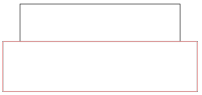

'{"image": "static/temp/1/side.png", "shape": "rectangle", "ratio": "0.0025706944907525446"}'

In [28]:
Dimensioning(userId,"side",side_image)

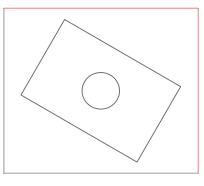

'{"image": "static/temp/1/top.png", "shape": "rectangle", "ratio": "0.002570694087403599"}'

In [29]:
Dimensioning(userId,"top",top_image)

In [30]:
#Multiply the outputed ratio by the width of the rectangle or the diameter in case of circle
"""This is done because lets say the images are taken from camera the the pixel to dimension ratio
might changes for each view, so we take the pixel to dimension ratio for converions"""
fratio = 0.0030303035907728883 * 34 #Width of rectangle in highlighted in front view 
sratio = 0.0025706944907525446 * 40 #Width of rectangle in highlighted in front view
tratio = 0.002570694087403599 * 40 #Width of rectangle in highlighted in front view

In [31]:
Convert(userId,front_image, side_image, top_image,fratio, sratio, tratio)



Subtree: 2


'"static/1.scad"'

In [23]:
import viewscad
from solid import *

r = viewscad.Renderer(openscad_exec='C:\Program Files\OpenSCAD\openscad.exe')
c = cylinder(h = 30.0, r=9);
r.render(c)